Bizim amacımız müşterilerimizi şu şekilde kategorilere ayırıp kategoriksel bazda ilgilenebilmek

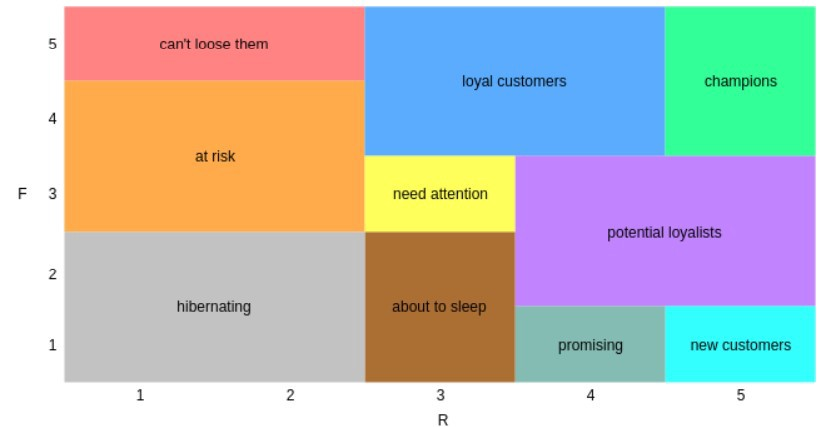

In [1]:
import pandas as pd
import datetime as dt
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df_ = pd.read_excel("D:/MVK/week3/Dosyalar/online_retail_II.xlsx",
                    sheet_name="Year 2010-2011")

In [3]:
df = df_.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[df["Quantity"]>=0]
df["Total_price"] = df["Price"] * df["Quantity"]


Invoice'un içerisinde C bulunanlarları kaldırdık. Çünkü faturasının içinde c olanlar iade içerdiği anlamına gelmektedir. Bu da  analizimizi yanlış yönlendirecek olduğundan kaldırdık. 

Ve her bir faturada her ürün için ödenen toplam ücreti hesapladık

### RFM Metriklerinin Hesaplanması

In [5]:
today_date = df.InvoiceDate.max() + dt.timedelta(days=3)
today_date
# today_date'i max tarihten 3 gün sonrası olarak hesapladık. 
# Bunu isteğimize göre değiştirebiliriz.

Timestamp('2011-12-12 12:50:00')

In [6]:
def RFM():
    """
    RFm Tablosunun oluşturduk
    """
    rfm = df.groupby("Customer ID").agg({"InvoiceDate":lambda date:(today_date-date.max()).days,
                    "Invoice": lambda num: len(num),"Total_price":lambda TotalPrice: TotalPrice.sum()})
    
    rfm.columns = ['Recency', 'Frequency', 'Monetary']
    rfm = rfm[(rfm["Monetary"]) > 0 & (rfm["Frequency"] > 0)]
    return rfm
        

In [7]:
def RFM_Score():
    """
    Oluşturulan RFM tablosundan, skorları hesapladık.
    Burada önemli olan nokta Recency ile diğerlerinin Labeller'ı farklı olmalı
    çünkü en son gelme tarihi ne kadar büyükse skoru o kadar düşük olmalı
    """
    rfm = RFM()
    rfm["RecencyScore"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1])
    rfm["FrequencyScore"] = pd.qcut(rfm["Frequency"], 5, labels=[1,2,3,4,5])
    rfm["MonetaryScore"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5])
    
    rfm["RFM_Score"] =  (rfm["RecencyScore"].astype(str) +\
                         rfm["FrequencyScore"].astype(str) + rfm["MonetaryScore"].astype(str))
    rfm["segment"] = rfm["RecencyScore"].astype(str) + rfm["FrequencyScore"].astype(str)

    return rfm
    

In [8]:
rfm = RFM_Score()
rfm

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score,segment
Customer ID,,,,,,,,
12346.0,328,1,77183.60,1,1,5,115,11
12347.0,4,182,4310.00,5,5,5,555,55
12348.0,77,31,1797.24,2,3,4,234,23
12349.0,21,73,1757.55,4,4,4,444,44
12350.0,312,17,334.40,1,2,2,122,12
...,...,...,...,...,...,...,...,...
18280.0,280,10,180.60,1,1,1,111,11
18281.0,183,7,80.82,1,1,1,111,11
18282.0,10,12,178.05,5,1,1,511,51


In [9]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4338 entries, 12346.0 to 18287.0
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Recency         4338 non-null   int64   
 1   Frequency       4338 non-null   int64   
 2   Monetary        4338 non-null   float64 
 3   RecencyScore    4338 non-null   category
 4   FrequencyScore  4338 non-null   category
 5   MonetaryScore   4338 non-null   category
 6   RFM_Score       4338 non-null   object  
 7   segment         4338 non-null   object  
dtypes: category(3), float64(1), int64(2), object(2)
memory usage: 216.7+ KB


In [10]:
my_list = [8,13,25,7,1,30,14]

In [11]:
print(pd.qcut(my_list,3,labels = [1,2,3]))


[1, 2, 3, 1, 1, 3, 2]
Categories (3, int64): [1 < 2 < 3]


In [12]:
print(pd.qcut(my_list,3,labels = [3,2,1]))

[3, 2, 1, 3, 3, 1, 2]
Categories (3, int64): [3 < 2 < 1]


### Regex ile segmentlere ad verilmesi

In [13]:
seg_map = {

    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At_Risk',
    r'[1-2]5': 'Cant_Loose',
    r'3[1-2]': 'About_to_Sleep',
    r'33': 'Need_Attention',
    r'[3-4][4-5]': 'Loyal_Customers',
    r'41': 'Promising',
    r'51': 'New_Customers',
    r'[4-5][2-3]': 'Potential_Loyalists',
    r'5[4-5]': 'Champions'
    }

rfm["segment_adi"] = rfm["segment"].replace(seg_map, regex=True)
rfm.head()

    

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score,segment,segment_adi
Customer ID,,,,,,,,,
12346.0,328,1,77183.60,1,1,5,115,11,Hibernating
12347.0,4,182,4310.00,5,5,5,555,55,Champions
12348.0,77,31,1797.24,2,3,4,234,23,At_Risk
12349.0,21,73,1757.55,4,4,4,444,44,Loyal_Customers
12350.0,312,17,334.40,1,2,2,122,12,Hibernating


Biz sadece "segment_adi","Recency","Frequency","Monetary" sütunlarını 

alsak yeterli ek olarak da her bir segmentte kaç kişi olduğunu bulduralım.

In [14]:
rfm_table = rfm.loc[:,["segment_adi","Recency","Frequency","Monetary"\
                ]].groupby("segment_adi").agg({\
                            "Recency":["count","mean"],"Frequency":"mean","Monetary":"mean"})
rfm_table.columns = rfm_table.columns.droplevel(0)

In [15]:
rfm_table.columns = ["count","Recency","Frequency","Monetary"]

In [16]:
rfm_table

,count,Recency,Frequency,Monetary
segment_adi,,,,
About_to_Sleep,326,55.751534,15.886503,476.379141
At_Risk,564,168.730496,56.785461,996.211755
Cant_Loose,81,148.271605,182.320988,2393.519148
Champions,606,7.905941,289.031353,6960.915446
Hibernating,1063,213.153340,13.597366,530.763539
Loyal_Customers,824,36.013350,156.718447,2833.505667
Need_Attention,203,54.817734,41.827586,857.195961
New_Customers,57,8.824561,7.578947,3618.697018
Potential_Loyalists,499,18.382766,34.873747,910.528259


### RFM Skorlarının Görselleştirilmesi

In [17]:
def showing(dataframe):
    for col in range(dataframe.shape[1]):
        plt.figure(figsize = (15,8))
        sns.set(font_scale = 1)
        column_name = dataframe.columns[col]
        plt.title(column_name)
        plt.plot(dataframe.iloc[:,[col]]);
        plt.show()
    

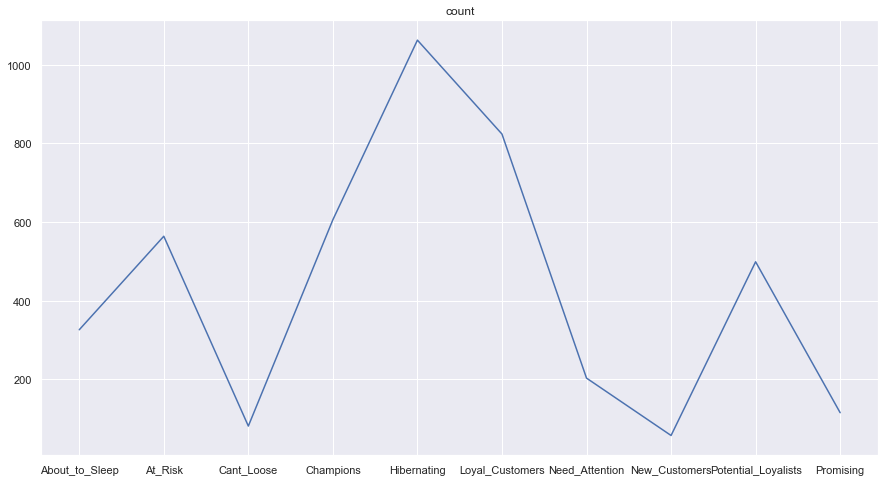

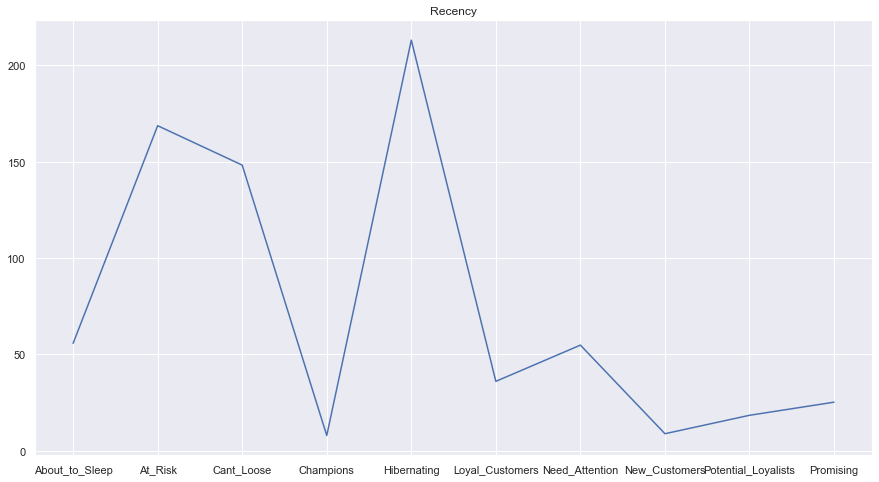

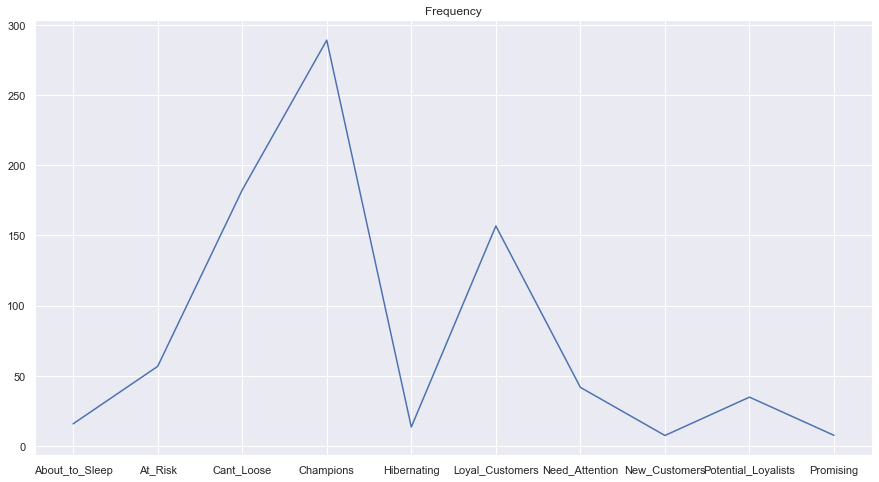

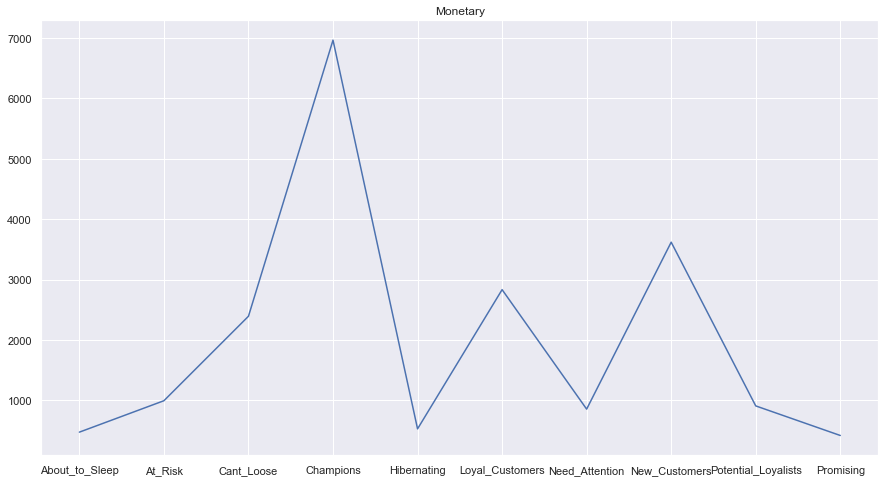

In [18]:
showing(rfm_table)